<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/super-opt-perturb/sequences/P2C1_CurveFitting/P2C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.1: Curve Fitting Through Perturbation**
In the first part of the book we gained insight into what the brain is for: rapid acquisition of adaptive behaviours. Now that we know what a brain is for we are going to start thinking about how it does what it needs to do. Instead of taking a bottom up approach grounded in observed physiological mechanisms, we are going to use a problem oriented, top down approach. That is, we will think about what problems the brain is solving and then survey the various physiological mechanisms that could feasibly implement algorithms that solve those problems. We will start with the problems that are simple to understand from a statistical and mathematical perspective; a broad sub-field of machine learning known as supervised learning. Supervised learning problems in ML presuppose many features without clear physiological counterparts in the brain. Nevertheless, we will start with algorithms where such counterpart are somehwat apparent and will draw connections to physiological mechanisms where we can. As more elaborate learning algorithms (un/semi-supervised learning, complex reinforcement learning) and their applications become clear, so too will the possible physiological implementations of unified neural system which feasibly solve the myriad statistical decision problems faced by living animals.

### Objective: Solve a simple problem using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Introduce a visual (binary) discrimination task.

* Build and train a simple 'neural circuit' model which 'learns' the binary discrimination based on scalar reward feedback.

* Relate the different aspect of our simple 'neural circuit' model to different neural plasticity mechanisms.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [4]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.1.1: Learning to Do The Right Thing - Easy

In our last chapter on evolution, we motivated much of our modeling using a binary classification problem in which a lurking predator had to choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the last chapter by highlighting the evolutionary advantage of (at least partially) learning these sensory-behaviour maps within an organism's lifetime due to variable environments and complex behaviors with non-linear fitness impacts. Here we shift our focus, and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' with-in the organism's lifetime, using feedback signals from the environment. Before we build a highly abstracted model of a neural circuit to solve this problem, let's test if your neural network is up to the task. Given a sensory input pattern, determine whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.

In [5]:
class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # intialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

For us at least, this task wasn't too hard, the simple association, strike when the center pixels are relatively light, don't strike when the center pixels are dark works well. So we can do this with our eyes and brains, now let's see if we can come up with a way to program an algorithm that will learn this association. The data set that underlies this strike-no-strike decision problem comes from the UCI Machine Learning Repository (Alpaydin,E. and Kaynak,C. (1998). https://doi.org/10.24432/C50P49.) Let's take a quick look at the data before we start coming up with a simple machine learning algorithm to correctly separate the cases when we should strike from when we should not.

In [6]:
# what is the shape and type of the data we have to work with
print(f'features data type: {X_simple_1_feature.dtype}')
print(f'features shape: {X_simple_1_feature.shape}')
print(f'labels data type: {y1_simple.dtype}')
print(f'labels shape: {y1_simple.shape}')

features data type: float64
features shape: (1125, 1)
labels data type: int64
labels shape: (1125, 1)


In [7]:
# what do the labels look like, what is their range
print(y1_simple[:10])
print(f'max label: {np.max(y1_simple)}')
print(f'min label: {np.min(y1_simple)}')

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
max label: 1
min label: 0


In the game we setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [8]:
# what do the features look like, what is there range
print(X_simple_1_feature[:10])
print(f'max features: {np.max(X_simple_1_feature)}')
print(f'min features: {np.min(X_simple_1_feature)}')

[[-6. ]
 [-6. ]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 4.5]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 6. ]]
max features: 6.0
min features: -6.0


In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker feature values.

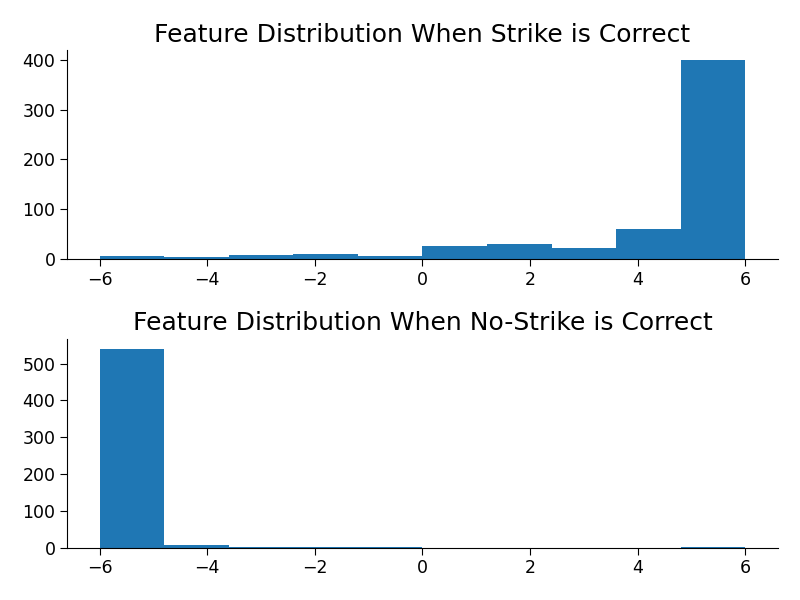

In [9]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the feature across these two classes (strike vs. no-strike situations) we see that we should be able to correctly discriminate between these two cases most of the time using just this one feature. How we should do this?

Now, if we were acting as scientist (which we sometimes do!), we'd think hard and carefully about the specific physical processes behind these features (the ML term for model/sensory inputs) and labels (the ML term for 'correct answer'), and this would guide the types of analyses to perform on the data and the kinds of inferences and conclusions we could draw.
But in this moment, we're not acting as scientists in pursuit of deep understanding; we're acting as algorithm designers focused on figuring out how to do the right thing. We want come up with a process for 'learning a function' that takes this feature as an input and generates the correct behaviour (as defined by the labels) as a behavioural outputs. A zero label means no strike is the right thing to do (no prey present) and a one label means striking is the right thing to do (prey are present).  

As inspiration for our learning algorithm we imagine a very simple organism. One that has a signle sensory input neuron, in turn connected to a single output neuron by single synaptic weight. If the output neuron fires (spikes) the predator strikes, and if it does not fire the predator does not strike.

We model this creature's sensory-behaviour system as follows. Let $x$ be the raw sensory input (scalar) in a given episode. We imagine that $x$ corresponds to the activation level and firing rate of a single photosensitive neuron. This input neuron is then connected by a synapse to a single output neuron. The activation level of this output neuron is computed as
$$y = wx + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $w$ is the strength of the synaptic weight between the input neuron and the output neuron (is this case there is only one output and one input so $w$ is a scalar, in cases with multiple inputs and outputs we would use $\mathbf{W}$ to denote the matrix of such synaptic weights and $\mathbf{x}$ to denote the vector of sensory inputs. As a quick reminder, in our notation, bold lowercase letters represent column vectors, while bold uppercase letters denote matrices or higher-dimensional tensors.)  We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

**Quick Math Exercise**

Consider a random variable with two possible outcomes, $A$ and $B$. The probability of each outcome is determined by applying the softmax function to their respective scores, $a$ and $b$. Specifically, the probability of outcome $A$ occurring is given by the softmax formula:
$$ \Pr \{A\} = \frac{e^a}{e^a + e^b}$$
Interestingly, $\Pr{A}$ can be expressed in terms of the logistic (sigmoid) function, $\sigma(x)$, where $x$ is a function of the scores $a$ and $b$. Your task is to determine this function, denoted as $f(a, b)$, so that $\Pr{A} = \sigma(f(a, b))$.


Having established how behaviour is determined by sensory input, $x$, and parameters $w$, $b$, i.e. our policy, we now need to develop a rule for modifying this policy based on environmental feedback.

Our goal is to come up with a rule that prescribes changes to the synaptic weight $w$ and bias $b$ in such a way that the reward obtained over time increases (and ideally approaches the theoretical maximum over many learning trials).

Our previous 'guess and check' learning method from sequence 1.3.4, while not the most efficient, proved effective, as was the 'propose and reject' style algorithms that we explored earlier and that are akin to what evolution by natural selection implements. Building on this idea of 'propose and reject' we will perturb the existing weights by a small amount, evaluate the behaviour function using the perturbed weights. However, instead of just simply accepting or rejecting the proposed parameters (kind of like natural selection does) we will instead ***measure the relationship between the change in the performance of the the organism (in terms of reward obtained) and the changes in the parameters.*** An update will then be applied to the weights that is ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters. As a word equation

$$ \text{Parameter Update} \propto \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

The $\propto$ symbol stands for 'proportional to', which means that the two sides of the 'equation' are equal so long as one side is multiplied by the correction 'constant of proportionallity'. So another way to say this would be that

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality, in this case usually called the learning rate or step-size meta-parameter of the learning algorithm.

Already we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method. With 'propose and reject' we don't make any parameter updates unless 'better' parameters are proposed, so most of the information from evaluation is thrown away every time parameters are rejected. In contrast, 'measure and update' methods always updated parameters using the information gleaned from the tested parameters. Provided these parameter updates are making good use of the evaluation information, this should be more efficient.

Let's try it and see.

In [76]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evalution function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################

def np_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[0]
  h = np.zeros((batch_len, 1))
  R_bar = 0
  for ii in range(batch_len):
    h[ii,0] = w * x[ii,0] + b
    y_hat[ii,0] = np_sigmoid(h[ii,0])
    #y_hat is our probability of striking
    if y[ii,0] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_bar += y_hat[ii,0] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      # R_bar += (1-y_hat[ii,0]) * 0.0
    elif y[ii, 0] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_bar += y_hat[ii,0] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      #R_bar += (1-y_hat[ii,0]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_bar = R_bar / batch_len
  return R_bar

NotImplementedError: Exercise: parameter evaluation

In [82]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))
  # use alternate formulation of sigmoid for negative and positive values
  # to avoid overflow errors
  #return np.where(x >= 0,
  #                1 / (1 + np.exp(-x)),
  #                np.exp(x) / (1 + np.exp(x)))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_bar = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    #y_hat is our probability of striking
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_bar += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      # R_bar += (1-y_hat[ii,0]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_bar += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      #R_bar += (1-y_hat[ii,0]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_bar = R_bar / batch_len
  return R_bar


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar


In this exercise we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using numpy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [83]:
X_simple_1_feature.T.shape

(1, 1125)

In [84]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

0.46215956306090394

In [85]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

0.4621595630608997

In [86]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

3 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

50.7 µs ± 521 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In our specific example, the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for loops. This is because for loops in interpreted languages like Python incur significant overhead at each iteration, in part due to potential dependencies between loop iterations which limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX; broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

Okay so we have the ability to evaluate the parameters in terms of the average score the yeild when applied across the whole 'data set' of examples we have of senory inputs and correct actions. Let's start with 'neutral' parameters $w=1$ and $b=0$ and then in each iteration of our learning (training) loop we will perturb our parameters using a Gaussian noise, and then ***measure the relationship*** between the parameter changes and the average expected reward as determined by our evalutation function.

In [105]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 200 #learning rate / step size
perturbation_scale = 0.1 # std of guassian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + w_perturbation
  R_bar_perturbed_w = eval_params(w_perturbed, b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params(w, b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = (R_bar_perturbed_w - R_bar_old) / w_perturbation
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

   Iteration: 0      | w=5.5287   | b=2.4765   | R_bar=0.462160 | Time=0.00  seconds
   Iteration: 5000   | w=12.5186  | b=42.2319  | R_bar=0.495022 | Time=0.82  seconds
   Iteration: 10000  | w=14.3977  | b=48.6602  | R_bar=0.495067 | Time=1.63  seconds
   Iteration: 15000  | w=15.5291  | b=52.3596  | R_bar=0.495082 | Time=2.47  seconds
   Iteration: 20000  | w=16.2992  | b=55.0076  | R_bar=0.495089 | Time=3.28  seconds
   Iteration: 25000  | w=16.8975  | b=57.0190  | R_bar=0.495094 | Time=4.10  seconds
   Iteration: 30000  | w=17.3875  | b=58.6933  | R_bar=0.495097 | Time=4.92  seconds
   Iteration: 35000  | w=17.8059  | b=60.0948  | R_bar=0.495099 | Time=5.73  seconds
   Iteration: 40000  | w=18.1838  | b=61.3382  | R_bar=0.495100 | Time=6.56  seconds
   Iteration: 45000  | w=18.4996  | b=62.4001  | R_bar=0.495102 | Time=7.36  seconds
   Iteration: 50000  | w=18.7787  | b=63.3663  | R_bar=0.495103 | Time=8.17  seconds
   Iteration: 55000  | w=19.0346  | b=64.2503  | R_bar=0.495103 |

Is an R_bar of 0.4951... good or bad? Let's look at the data. How many striking opportunities are there, versus situation where no-strike is best?

In [52]:
# number of striking opportunities
np.sum(y1_simple == 1)

571

In [53]:
#number of non-strike situations
np.sum(y1_simple == 0)

554

In [54]:
# proportion of situations where a point can be earned
571 / (571 + 554)

0.5075555555555555

So, back to our question: Is an average score of 0.4951... per round good? Well, yes. A perfect score is 0.5075..., and given that we only have this one feature to work with - a feature that can't perfectly separate the two cases (as the distributions overlap a bit) - we are bound to have a few false positives and false negatives. These will lower the score a bit, but for the most part, this is roughly as good as can be expected.

**Algorithmic Thinking Exercise:**

In the 'measure and update' learning loop implemented above we perturb each parameter, measure the effect of perturbations, and then update the parameters. Alternatively we could have perturbed the $w$ parameter, evaluated and then updated the $w$ parameter, and then perturbed the $b$ parameter, evaluated, and then updated the $b$ parameter.
1. In the implementation above how many times is the `eval_params` function called per iteration?

  (Answer: 3)
2. If we used the alternative where each parameter is updated and after evaulation, how many times would`eval_params` need to be called per iteration?

  (Answer: 4, After updating $w$ we can't simply use `R_bar_old` to measure the change in performance from changing $b$ since `R_bar_perturbed_b` will be computed using the updated $w$. An `R_bar_new_w_old_b` will need to be computed and used to inform the changes to $b$.)
3. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the implementation above?

  (Answer: $n+1$)
4. If we had $n$ parameters and instead of 2, how many times would the `eval_params` function be called per iteration in the alternate implementation?

  (Answer: $2n$)

Little details like this in implementation can make big differences to algorithm speed. Note though that this slower alternative isn't quite a dead loss. Technically the parameter updates made by the alternative algorithm, will be 'better' (precisely what we mean by better we leave aside for the moment), however, in this particular case the 'betterness' of the parameter updates is not enough to make up for the added computational cost of calling `eval_params` and extra $n-1$ times.

Okay, now just as a sanity and intuition check, two questions:
1. Do we get the same answer when we use a propose and reject method?  
2. Is the propose and reject method quicker or slower at finding the solution?
Let's quickly adapt the above learning loop to do 'propose and reject' instead 'measure and update'

In [113]:
# @title Propose And Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 50000
perturbation_scale = 0.1 # std of guassian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
R_bar_best = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
for ii in range(num_learning_episodes+1):
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_proposed = w + w_perturbation
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_proposed = b + b_perturbation
  R_bar_proposed = eval_params(w_proposed, b_proposed, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    w = w_proposed
    b = b_proposed
    R_bar_best = R_bar_proposed

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')


   Iteration: 0      | w=1.0126   | b=-0.0132  | R_bar=0.462282 | Time=0.00  seconds
   Iteration: 5000   | w=22.7476  | b=76.8841  | R_bar=0.495109 | Time=0.28  seconds
   Iteration: 10000  | w=44.4480  | b=149.9137 | R_bar=0.495111 | Time=0.58  seconds
   Iteration: 15000  | w=64.4558  | b=217.5533 | R_bar=0.495111 | Time=0.91  seconds
   Iteration: 20000  | w=74.7534  | b=252.2891 | R_bar=0.495111 | Time=1.22  seconds
   Iteration: 25000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=1.57  seconds
   Iteration: 30000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=2.05  seconds
   Iteration: 35000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=2.52  seconds
   Iteration: 40000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=3.00  seconds
   Iteration: 45000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=3.46  seconds
   Iteration: 50000  | w=75.7098  | b=255.5117 | R_bar=0.495111 | Time=3.95  seconds


Okay so both 'Propose and Reject' and 'Measure and Update' get to similar answers, but 'Propose and Reject' get's there much more quickly. In part this is because there are fewer calls to `eval_params` per iteration, but also this is because the step size (in parameter space) stays relatively large throughout the process, whereas the step size (in parameter space) in our 'Measure and Update' process diminishes as the relative improvements in performance diminish. This is one reason why the improvements in `R_bar` are initially rapid, but slow down in the 'Measure and Update' process.

A couple things to think about here:
1. In our 'Measure and Update' training loop we make one perturbation and one measurement of change in reward for each parameter. What would happen if we perturbed every parameter and then made a single measurement of change in reward? This would me only two calls to `eval_params` per iteration, regardless of the number of parameters. Together these two `eval_params` would measure the combined effect of all the parameter changes on reward. As a result the estimated effect of any one parameter on the reward, would be polluted by the effects of all the other parameter perturbations. Would the efficiency from fewer `eval_params` calls compensate for the noise introduced? Is it better to take more/quicker noisy steps in parameters space or fewer/slower steps in better directions?
2. In the learning loops above the impact on reward for a perturbation is measured using the entirety of the data set available to us. In this example the data set is only ~1000 examples, but what if it consisted of trillions of examples, would it still make sense to use the entire data set to evaluate each perturbation or would it be better to evaluate parameter changes using a smaller sample from this data set? Using a smaller sample will often make our evaluations faster at the price of introducing noise to the estimate of rate of reward change (on the full data set) with respect to parameter changes. Again, this is question of more/quicker noisy steps or fewer/slower careful steps in parameters space.
3. In the learning loops above we measure the relationship between parameter changes and reward changes using a single perturbation, but could we make better parameter updates if we measured using many perturbations before updating the parameters? This would require making more evaluations per update, again it comes down to more/quicker noisy parameter updates versus fewer/slower careful parameter updates. What is the right balance?

For this very straightforward problem these questions may seem kind of beside the point. We have a good answer, and it didn't take too long to get, why worry about these details now? We don't really need to now, but as we'll soon see, these details become increasingly relevant as we work to extend this measure and improve approach to more complex problems. Indeed, the trade-off between more/quick noisy steps and few/slow careful steps is one of the fundamental questions at the dark heart of Machine Learning.

In [55]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Learning to Do The Right Thing - Harder
In the previous section we worked on a pretty simple discrimination problem, there was a single feature that (for the most part) correlated with when striking was and wasn't the right thing to do. Now we're going to look at a slightly harder problem, where the answer is less obvious (to us at least). As before, given a sensory input pattern, the problem is to determine whether or not to strike. Again, try to maximize your average score. Now though, the 'sensory' pattern is more complex.

In [56]:
scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

So now instead of a single feature to base our strike/no-strike discrimination on we have 64 (8x8) features to potentially inform our decision. Will our simple setup from before readily generalize to this situation with richer sensory input? Let's find out.

We model this creature's sensory-behaviour system much as before. Now $\mathbf{x}$ is the raw sensory input (vector) in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [57]:
# the data set we're working with has 5620 example sensory inputs,
# each consistinge of 64 (8x8) values
print(Xs.shape)

(5620, 64)


In [58]:
# this is the first example
print(Xs[0].reshape(8,8,))

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.  ]
 [-6.   -6.   -2.25 -0.75  4.5  -1.5  -6.   -6.  ]
 [-4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25]
 [-0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75]
 [-6.   -5.25  5.25  0.   -6.    1.5   3.   -0.75]
 [-6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.  ]
 [-6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5 ]
 [ 6.    6.   -6.   -6.   -3.   -6.    0.75 -6.  ]]


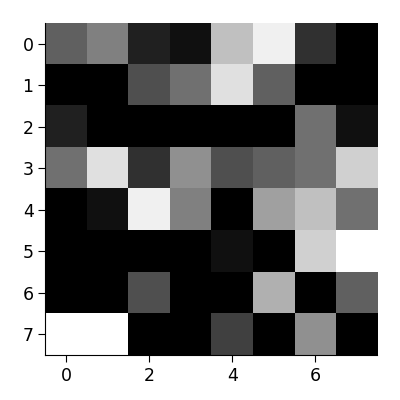

In [59]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
As before, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could aslo be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

In [60]:
def eval_params_rich(W, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) + b # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

In [61]:
eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

1.4359891754087803e-28

In [62]:
%timeit eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

727 µs ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That's working and relatively quick now let's adapt our learning loop for this new setup.

In [114]:
learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
alpha = 0.05 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
W_init = np.zeros((1,64))
b_init = 0
W = W_init
b = b_init
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params_rich(W, b, Xs.T, y1.T)
  # get pertubations for W all at once
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,64))
  #perturb and evaluate each W_j seperately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    W_perturbed = np.copy(W)
    W_perturbed[0,j] += W_perturbations[0,j]
    R_bar_perturbed_Wj = eval_params_rich(W_perturbed, b, Xs.T, y1.T)
    finite_difference_Wj = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,j]
    finite_differences_W[0,j] = finite_difference_Wj
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params_rich(W, b_perturbed, Xs.T, y1.T)
  # estimate rate of change of reward for each parameter
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_W = alpha * finite_differences_W
  delta_b = alpha * finite_difference_b
  W += delta_W
  b += delta_b

  if ii == 0 or ii % 100 == 0:
    print(f'Episode {ii}, W_0={W[0,0]}, b={b}, R_bar={R_bar_old}')
    #print(f'Episode {ii}, W={W}, b={b}, R_bar={R_bar_old}')

Episode 0, W_0=0.010409252323206525, b=8.451957219165112e-05, R_bar=0.0033807829181494663
Episode 100, W_0=0.0689569608421781, b=-0.0034781971230943786, R_bar=0.3983616155615579
Episode 200, W_0=0.08179888996847834, b=-0.005096718518600812, R_bar=0.4096989636521237
Episode 300, W_0=0.09059147657460451, b=-0.006320810231388481, R_bar=0.4149245803068831
Episode 400, W_0=0.09720643688859762, b=-0.007324739123348085, R_bar=0.41813524414336367
Episode 500, W_0=0.10255557391208067, b=-0.008204797195087932, R_bar=0.42040749010938266
Episode 600, W_0=0.10702096946552672, b=-0.00900165643773758, R_bar=0.42215259029938795
Episode 700, W_0=0.11097352550201442, b=-0.009740322554175871, R_bar=0.42355704699288343
Episode 800, W_0=0.11460147071781174, b=-0.01043442418757362, R_bar=0.424718549640681
Episode 900, W_0=0.11797206881790907, b=-0.011092927588059052, R_bar=0.4256987303500359
Episode 1000, W_0=0.12111127940917828, b=-0.01171741925845506, R_bar=0.42653813818695757
Episode 1100, W_0=0.12403880

From the data set some benchmark

2.1.1.3: Better Ways to Learning How to Do The Right Thing

In [ ]:
def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[0]
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

eval_params_quick(1, 0, X_simple_1_feature, y1_simple)

In [ ]:
%timeit eval_params_rich(np.ones(), 0, X_simple_1_feature, y1_simple)


In a given learning episode one of four cases can occur:

1. Prey is present, given the sensory input the organisms strikes, a positive reward is obtained
2. Prey is not present, given the sensory input the organism strikes, a negative reward is obtained
3. Prey is present, given the sensory input the organism does not strike, no reward is obtained
4. Prey is not present, given the sensory input the organism does not strike, no reward is obtained

We have the (initial) caveat that from the perspective of the organisms cases 3 and 4 are identical, so the parameter update rule must also be identical in each of those cases.

It has been noted and proposed many times that the inherent stochasticity of synaptic firing might provide a kind of natural 'guess' and allow for this kind of learning to be implemented in the brain, [citations]. Empirical evidence for this kind of learning is also begining to accumulate [citations].

The basic idea is as follows. Due to the stochastic spiking of neurons, in any given episode of senosry input -> behaviour production -> contingent reward, some but not all of the synaptic weights are causally implicated in the production of the behaviour (and consequent reward). When a good thing happens, synaptic connections that were involved in the generation of the behaviour should be strengthened, and conversely when bad things happen synaptic connections that were involved in the generation of the behaviour should be weakened. Synaptic connections that were not involved in producing the behaviour should be left unchanged. Zooming in to the synaptic level the four cases above are expanded as follows:

1. Both input and output neurons spike, a good thing happens
2. Both input and output neurons spike, a bad thing happens
3. Input neuron spikes but output neuron doesn't spike, a neutral thing happens
4. Input neuron doesn't spike, output neuron spikes, a good thing happens
5. Input neuron doesn't spike, output neuron spikes, a bad thing happens
6. Neither input nor output neuron spikes, a neutral thing happens.

In this our first and most simple (from a physiological mechanism perspective, actually a bit complicated from a mathematical description perspective), only in the first two cases, when both the pre- and post- synaptic neurons fire, is the synapse causally implicated in the reward outcome. So our rule needs to prescribe no change, unless both pre- and post- synaptic neurons have fired. If a good thing happens, then the connection should be reinforced, and if a bad thing happens then the connection should be weakened. Our learning rule written to echo and presiage the 'REINFORCE' formulation of Williams (1992), and also Resrola Wagnar rule, and also TD formulations. In some sense this is cannonical form of learning rules is.

$$\Delta w_i = \alpha \cdot (r - b) \cdot s_i \cdot s_o$$

Almost every learning rule for parameters that we look at will be roughly composed of these three factors: learning rate, error, eligibility. The first factor is positive learning rate or step size parameter of the learning process. In this specific case $\alpha$ is constant, but it could be made contingent on various factors in more complicated models, e.g. learning rates often start high and are lowered as the learning system gets more 'dialed in'. The second part is an 'error' term, in this case a 'reward prediction error', $(r-b)$, gives the way in which the actual received reward $r$ differs from some baseline expectation. Again in more complicated learning rules $b$ could be made contingent on many factors, and this contingency of $b$ on other factors might itself be learned. Here though, we assume a constant expected reward, $b=0$, so we can think of $b$ as an expectation of how good the world is on average, if the organism is performing as well as expected. We imagine that parameters like $\alpha$ and $b$ are set and tuned by evolution to ensure effective learning. Lastly, in this simple model the $s_i \cdot s_o$ term is the 'eligibility' of the synapse for change. In general, this will be some measure of how causally implicated the particular parameter $w_i$ is in causing the received reward. Here we use one of the simplest possible eligibility terms, which takes the value one only when both pre- and post- synaptic neurons fire, and is otherwise zero. Again in more complicated learning rules, this eligibility term could be more complicated, e.g. it might incorporate knowledge of the structure of the network producing the behaviour, often in the form of a gradient, to further modulate the strength and direction of the weight change. Note, $w_i$ is the $i^{\text{th}}$ element of $\mathbf{W}$ and $s_i$ and $s_o$ are the realized spikes during the episode for the $i^{\text{th}}$ input neuron and the output neuron respectively. Okay, let's implement and see how well this works!

We model this creature's sensory-behaviour system as follows. Let $\mathbf{x}$ be the raw sensory input vector in a given episode. We imagine that each element of $\mathbf{x}$, denoted $x_i$ corresponds to the activation level of a single photosensitive neuron. These activation levels might be losely interpreted as firing rates. This input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx}$$
Here, $\mathbf{W}$ is the matrix of synaptic weights between the input neurons and the output neuron (is this case there is only one output so $\mathbf{W}$ is effectively a row vector). As a quick reminder, in our notation, bold lowercase letters represent column vectors, while bold uppercase letters denote matrices or higher-dimensional tensors. We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(x): \frac{1}{1+e^{-x}} = \frac{e^x}{1+e^x}$ is the standard logistic (sigmoid) function.

In [ ]:


def learning_episode(W, x, target, rng, alpha=0.01, b=0, ):
  #forward pass, generate behaviour
  sensory_nueron_spike_probs = np_sigmoid(x)
  sensory_neuron_spikes = rng.binomial(1, sensory_nueron_spike_probs)
  output_neuron_activation = np.dot(W, sensory_neuron_spikes)
  output_neuron_spike_prob = np_sigmoid(output_neuron_activation)
  output_neuron_spike = rng.binomial(1, output_neuron_spike_prob)
  #evaluate behaviour
  reward = output_neuron_spike * target
  # backward pass,update parameters
  W += alpha * (reward - b) * output_neuron_spike * sensory_neuron_spikes
  return W, reward, output_neuron_spike, output_neuron_spike_prob

In [ ]:
# Now embedd those learning episodes in a training loop
# pre calculate activation to probability for efficiency
train_rng = np.random.default_rng(1234)
W = train_rng.standard_normal(size=(1, Xs.shape[1]))

epochs = 500  # Number of times to iterate over the dataset
performance_tracker = {'cumulative_reward': [], 'accuracy': [],
                       'TP':[], 'FP':[], 'TN':[], 'FN':[],}
max_possible_reward = np.sum(y1==1)
alpha=0.00001
b=0
pbar = tqdm(range(epochs), desc='Training Progress')
for epoch in pbar:
  cumulative_reward = 0
  TP, FP, TN, FN = 0, 0, 0, 0
  shuffled_indices = train_rng.permutation(Xs.shape[0])
  for i in shuffled_indices:  # Iterate over each example
    x = Xs[i]
    target = y1[i]
    W, reward, output_neuron_spike, _ = learning_episode(W, x, target,
                                                         train_rng, alpha, b)
    # Track performance
    cumulative_reward += reward
    # Update confusion matrix
    if output_neuron_spike == 1 and target == 1:
      TP += 1
    elif output_neuron_spike == 1 and target == -1:
      FP += 1
    elif output_neuron_spike == 0 and target == 1:
      FN += 1
    elif output_neuron_spike == 0 and target == -1:
      TN += 1
  epoch_accuracy = (TP + TN) / Xs.shape[0]
  performance_tracker['cumulative_reward'].append(cumulative_reward)
  performance_tracker['accuracy'].append(epoch_accuracy)
  # Store confusion matrix values
  performance_tracker.setdefault('TP', []).append(TP)
  performance_tracker.setdefault('FP', []).append(FP)
  performance_tracker.setdefault('TN', []).append(TN)
  performance_tracker.setdefault('FN', []).append(FN)
  pbar.set_postfix({
        'Acc': f'{epoch_accuracy:.4f}',
        'Cum. Reward': cumulative_reward/max_possible_reward,
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    })

In [ ]:
# if we visualize the features do they look like anything?
plt.imshow(Xs[0,:].reshape(8,8), cmap='gray')
plt.show()

In [ ]:
# Plot cumulative reward
plt.subplot(1, 2, 1)
plt.plot(performance_tracker['cumulative_reward']/max_possible_reward)
plt.title('Normalized Cumulative Reward Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Reward')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(performance_tracker['accuracy'])
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
plt.hist(W.flatten())
plt.show()

In [ ]:
scramble_full_imp = InteractiveMNISTPredator(just_01=False)
display(scramble_full_imp.fig.canvas)
clear_output()
display(scramble_full_imp.ui)

**Coding Exercise: Implement minimal trial and error learning.**

On each learning round $t$ each individual who has yet to experience variable payoffs tries a new neural parameter configuration distributed as $g'(t)$ above, and receives a resulting score $z(g'(t))$. Additionally each round some proportion of the target $y$ is subject to change with some fixed probability. Let's adapt our evolutionary simulation function from the previous sequences to implement this simple form of learning and environmental change:

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... that are wrapped in lines
# of # ~~~~ to implement this learning rule within our evolutionary simulation.
# Note that sometimes ellipsis '...' are used when indexing numpy arrays,
# these ellipsis are not meant to be changed or edited as part of the exercise
# Also, note that the simulation function is long and complex. Often when
# programming the primary challenge is not writing the code, but finding where
# the code needs a very small change. This exercise aims at developing this
# ability.
raise NotImplementedError("Exercise: implement simple learning rule")
################################################################################


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # initialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # initialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # update flexible params where learning is still happening
        to_update = np.logical_and(...)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[to_update] = ...
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # trial scores are computed for everyone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # These lines are part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~
        # our learning rule is stop after any improvement
        is_fixed[improved] = ...
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = ...
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Define a range of environmental change rates
env_change_rates =[0.0, 0.01, 0.1, 0.5]

# Initialize dictionaries to store the full histories
score_histories = {rate: [] for rate in env_change_rates}
flexible_change_histories = {rate: [] for rate in env_change_rates}
flexible_no_change_histories = {rate: [] for rate in env_change_rates}

# Run simulations for each change rate
for rate in env_change_rates:
  simulation_results = evo_learning_simulation(
      env_change_rate=rate,
    )
  # Store the full histories
  score_histories[rate] = simulation_results['mean_score_hist']
  flexible_change_histories[rate] = simulation_results['mean_flexible_change_hist']
  flexible_no_change_histories[rate] = simulation_results['mean_flexible_no_change_hist']

# Plotting using the object-oriented approach
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Mean Score Histories
for rate, history in score_histories.items():
    axs[0].plot(history, label=f'Change Rate {rate:.2f}')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Score')
axs[0].set_title('Mean Score Over Generations')
axs[0].legend()

# Plot Mean Flexibility for Change Eligible Histories
for rate, history in flexible_change_histories.items():
    axs[1].plot(history, label=f'Change Rate {rate:.2f}')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Flexibility (Change Eligible)')
axs[1].set_title('Mean Flexibility (Change Eligible) Over Generations')
axs[1].legend()

# Plot Mean Flexibility for No Change Eligible Histories
for rate, history in flexible_no_change_histories.items():
    axs[2].plot(history, label=f'Change Rate {rate:.2f}')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Mean Flexibility (No Change Eligible)')
axs[2].set_title('Mean Flexibility (No Change Eligible) Over Generations')
axs[2].legend()

remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

In [ ]:
# to_remove solution


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # initialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # initialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # update flexible params where learning is still happening
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[to_update] = update_param_samples
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # trial scores are computed for everyone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # These lines are part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Define a range of environmental change rates
env_change_rates =[0.0, 0.01, 0.1, 0.5]

# Initialize dictionaries to store the full histories
score_histories = {rate: [] for rate in env_change_rates}
flexible_change_histories = {rate: [] for rate in env_change_rates}
flexible_no_change_histories = {rate: [] for rate in env_change_rates}

# Run simulations for each change rate
for rate in env_change_rates:
  simulation_results = evo_learning_simulation(
      env_change_rate=rate,
    )
  # Store the full histories
  score_histories[rate] = simulation_results['mean_score_hist']
  flexible_change_histories[rate] = simulation_results['mean_flexible_change_hist']
  flexible_no_change_histories[rate] = simulation_results['mean_flexible_no_change_hist']

# Plotting using the object-oriented approach
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Mean Score Histories
for rate, history in score_histories.items():
    axs[0].plot(history, label=f'Change Rate {rate:.2f}')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Score')
axs[0].set_title('Mean Score Over Generations')
axs[0].legend()

# Plot Mean Flexibility for Change Eligible Histories
for rate, history in flexible_change_histories.items():
    axs[1].plot(history, label=f'Change Rate {rate:.2f}')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Flexibility (Change Eligible)')
axs[1].set_title('Mean Flexibility (Change Eligible) Over Generations')
axs[1].legend()

# Plot Mean Flexibility for No Change Eligible Histories
for rate, history in flexible_no_change_histories.items():
    axs[2].plot(history, label=f'Change Rate {rate:.2f}')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Mean Flexibility (No Change Eligible)')
axs[2].set_title('Mean Flexibility (No Change Eligible) Over Generations')
axs[2].legend()

remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

The simulation results above help illustrate how the adaptive balance between learning (plasticity) and genetic determination shifts in response to environmental variability.

In the first plot "Mean Score Over Generations", we see a clear trend: stable environments lead to higher and more rapidly stabilizing mean scores (blue line, change rate = 0.00, orange line, change rate = 0.01). As the environment's change rate increases (red and green lines), mean scores become more erratic and generally lower. This aligns with the expectation that optimization through evolution will always lag behind in dynamic environments where the 'ideal phenotype' can change from generation to generation.

The second plot, "Mean Flexibility (Change Eligible) Over Generations", tracks the evolution of the mean proportion of learning-determined loci, for those loci associated with fluctuating environmental targets (there are 10 such loci in these particular simulations). The plot shows a higher mean flexibility at loci where environmental targets change frequently (green, 0.1, and red, 0.5, lines) compared to loci with slow or no change (orange, 0.01, and blue, 0.0, lines respectively). This suggests that learning is advantageous and selected for when environmental unpredictability is high, as it gives organisms a way to rapidly adjust to new conditions within their lifetime and thus reduces dependence on genetic changes over generational time to cope with environmental dynamics (so called adaptive tracking). When the environmental volatility is very high (red, 0.5) there is basically no evolutionary tracking of the variable environment, and learning/plasticity dominates. In contrast, at an intermediate level of volatility (green, 0.1) we see that a combination of adaptive tracking and plasticity is stable within the population.

The "Mean Flexibility (No Change Eligible) Over Generations" plot serves as a sanity check, confirming that where environmental targets don't change, learning is selected against. When there is no environmental variability full genetic determination is selected for.

The overarching message from these simulations is clear: genetic determination is beneficial in static environments where the optimal phenotype is constant. In such cases the 'correct phenotype' can in some sense be known fully by the genome and so should simply be developed as rapidly as possible. In such cases learning and other forms of phenotypic plasticity that might slow development have no adaptive value. Conversely, in volatile environments, learning and plasticity can be selected for. Note that in these simulations all of the many mechanisms required for effective plasticity have been abstracted away, e.g. the details of how flexible development/neural plasticity, evaluation of different outcomes, sensing the environment, etc. is achieved is left completely unanswered and so these simulations serve only to hint at the kinds of scenarios when such mechanism could be evolutionarily favoured, without giving any consideration to the costs associated with developing and maintaining such mechanisms.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.4.2: Some Fitness Score Functions are Hard for Evolution to Optimize

In the previous section we saw how evolutionary processes are responsive to (but not anticipatory of) environmental change, and how as a result, in a changing environment the population phenotype will often lag behind the optimal phenotype for a given environment. We also saw how within lifetime learning could be an adaptive response to dealing with environmental change and uncertainty. In the previous simulations the connection between a genetic change and the fitness increment was quite direct given the structure of the fitness score function (the sum of 'correct' alleles) and so as a result selection was able to (relatively) rapidly steer the population towards good phenotypes for the given environment. This is not always the case.

Genes rarely operate in isolation. They are typically part of dynamic networks, engaging in a molecular dialogue to orchestrate complex patterns of gene expression. These networks shape the diverse phenotypes (traits) we observe, from physical characteristics to behavioural patterns. Pleiotropy, where a single gene influences multiple traits, and epistasis, where the effect of one gene is significantly shaped by others, are the norm rather than the exception. Consequently, most traits are polygenic, emerging from the collective influence of multiple genes. Note that in our models we rarely consider these complications, and for the illustrative goals of most of our models we do not need to. However, if and when the goal of modeling becomes quantitative prediction actual empirical gene frequencies, these details, in particular when they can and cannot be ignored in modeling, do become critical.

For a moment now though we *are* going to consider how a very simplified form of epistasis can result in a fitness score function that is much more difficult for an evolutionary process to optimize.

We will continue to use the 'strike-no-strike' decision problem but with some added complexity. We still consider an organism with $n$ chemosensory receptors, each corresponding to $n$ possible food/non-food chemical markers in the environment. However, now the functionality of these receptors is determined by $nk$ distinct genetic switches, represented as a bit-string $g$ of length $nk$ with every block of $k$ contiguous bits determines the efficacy of the receptor in the strike-no-strike game. Instead of thinking of each genetic bit as corresponding to the expression or absence of a receptor for a particular marker, we instead think of each genetic bit as determining some connections in a neural circuit between receptors and muscles and only a very particular set of connections allows for the effective use of the receptor. In our learning simulations above we had a kind of epistasis where the the impact of the $g$ (preset) type loci was dependent on the the $f$ (flexibility) type loci. Here we have an even stronger form of epistasis where the fitness impact of any one $g$ type loci is fully dependent on the other genes that share its receptor block.

In  the previous model having the 'correct' allele, i.e. $g_i = y_i$, at any loci, conferred a small, independent, additive benefit to fitness score. Now having the correct allele at a given loci, only provides a fitness score benefit if the other $k-1$ loci in that 'receptor block' on the genome also happen to be correct, otherwise the independent effect of that loci is neutral.

Making the same rough interpretation as before when a given block of connections aligns with the target neural circuit configuration the particular behaviour the neural circuit governs becomes better suited to the environment with the resulting impact on fitness score. This gives us our single trial fitness score as

$$ z(g):= \sum_{i=0}^{n-1} \prod_{j=1}^{k} I(y_{j+ik} = g_{j+ik}) $$

**Coding Exercise: Implement the new fitness score function.**

Each individual in the population has a genotype $g$, and a resulting score per trial $\sum_{i=0}^{n-1} \prod_{j=1}^{k} I(y_{j+ik} = g_{j+ik})$ i.e. the number of blocks of entirely 'good bits'. We will leave learning and environmental change out of our simulation in this first instance. Here $g$ is the genetic specification of the neural circuit $y$ is the target and $I$ is an indicator function. Let's adapt our evolutionary simulation function from before to use this new fitness score function.

In [ ]:
################################################################################
# TODO for students: Complete the score_calc function definition to implement
# this new per-trial score function. Hints, 1) think hard about the shapes of
# the composite_params and env_target arrays, 2) use numpy broadcasting to
# compare all composite_params to the target 3) use numpy sum and prod functions
# along specific axis, 4) play around with small test arrays in other (new)
# code cells before implementing your solution.
raise NotImplementedError("Exercise: implement complex score function")
################################################################################


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # initialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # initialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = ...
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.01,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'crossover',
    'has_learning': False,
    'n_learning_trials': 1,
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
}

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types = ['proportional', 'deterministic truncation', 'softmax']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
labels = {'proportional': 'Proportional', 'deterministic truncation': 'Deterministic Truncation', 'softmax': 'Softmax'}

# Define parameter dictionaries for each block size
#vary num_blocks with block_size to keep constant genotype length = num_blocks * block_size
block_sizes =       [ 2, 5, 10, 20]
numbers_of_blocks = [10, 4,  2,  1]
block_params = []
for block_size, num_blocks in zip(block_sizes, numbers_of_blocks):
  params = {'block_size': block_size, 'num_blocks': num_blocks}
  block_params.append(params)

# Plot for each selection type
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]
  label = labels[selection_type]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params,
                       **block_param,
                       'selection_type': selection_type}
    r = evo_learning_simulation(**combined_params)
    generations = np.arange(combined_params['n_gen'])

    # normalized mean score and quartiles
    mean_hist = r['mean_score_hist']/combined_params['num_blocks']
    ax.plot(generations, mean_hist, color=color, label=label + " - Block Size: {block_param['block_size']}, Block Number: {block_param['num_blocks']}")
  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Bits per Block')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In [ ]:
# to _remove solution


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # initialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # initialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.01,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'crossover',
    'has_learning': False,
    'n_learning_trials': 1,
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
}

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types = ['proportional', 'deterministic truncation', 'softmax']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
labels = {'proportional': 'Proportional', 'deterministic truncation': 'Deterministic Truncation', 'softmax': 'Softmax'}

# Define parameter dictionaries for each block size
#vary num_blocks with block_size to keep constant genotype length = num_blocks * block_size
block_sizes =       [ 2, 5, 10, 20]
numbers_of_blocks = [10, 4,  2,  1]
block_params = []
for block_size, num_blocks in zip(block_sizes, numbers_of_blocks):
  params = {'block_size': block_size, 'num_blocks': num_blocks}
  block_params.append(params)

# Plot for each selection type
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]
  label = labels[selection_type]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params,
                       **block_param,
                       'selection_type': selection_type}
    r = evo_learning_simulation(**combined_params)
    generations = np.arange(combined_params['n_gen'])

    # normalized mean score and quartiles
    mean_hist = r['mean_score_hist']/combined_params['num_blocks']
    ax.plot(generations, mean_hist, color=color, label=label + " - Block Size: {block_param['block_size']}, Block Number: {block_param['num_blocks']}")
  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Bits per Block')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In the simulations above we see the evolution of the (normalized) mean fitness score for different selection types, and different numbers of bits required to align before a fitness increment ([2, 5, 10, 20]). In each simulation there is mutation (but no recombination) to introduce new variance, yet the evolutionary process is unable to hit upon having all 20 bits in a receptor align at once (darkest lines) over 500 generations for any of these selection types. Fitness score functions like this, where a large co-adaption is required for any fitness increment, are sometimes referred to as 'needle-in-a-haystack' as there is one correct configuration, the needle, hidden among many, in this case roughly one million ($2^{20}$), incorrect configurations, the haystack. What makes this such a challenging problem for an evolutionary process is that all of the incorrect configurations look the same to selection; even though a configuration of one 'wrong' bit and nineteen 'right' bits is very close to the correct configuration in the genome space, from the perspective of selection, this close but wrong configuration is indistinguishable from any of the other wrong configurations. Selection gives no 'hot' or 'cold' style hints in this case to guide the evolutionary search. This is in stark contrast to the similar problem we looked at in the beginning of the sequence where selection was sensitive to every changing bit in the genome. For subsequent simulations we use 'proportional' selection, primarily for the sake of following Hinton and Nolan 1987.

Note though that even if the high scoring genotype is discovered through mutation and recombination, selection may not always be able to grow the frequency of this genotype within the population. Search and discovery with a so called 'flat' fitness landscape is just one aspect of the issue here. Additionally when using evolutionary search to find a large, tightly co-adapted configuration, recombination can be a liability. Consider that when this co-adaptation is discovered, if there is recombination then it is not easily passed on to descendants. When an adapted individual mates with any individual other than one almost identical to itself, the co-adaptation is likely to be destroyed by recombination. The crux of the issue is that for large co-adaptions very few, if any, improved genotypes are likely to appear in a given generation, and unless mating is strongly assortative these individuals are unlikely to mate with each other. For the co-adaptation to persist from generation to generation each good genotype must, on average, give rise to at least one good offspring in the next generation. If the dispersal of complex co-adaptations due to mating causes each good genotype to have less than one expected good offspring, the co-adaptation will not spread, even if it is discovered many times.


**Math Exercises:**

With some combination of large population size and many generation mutation alone (without recombination) will eventually hit upon this rare configuration. Assume a population of size $N$ where each individual has a single block of $n$ bits to be aligned

**Question 1.**
Calculate the approximate probability of an offspring with a 'good block' being born in a population where none of the previous generations have had a 'good block'. Use the following simplifying assumptions and hint:

> - Each bit in a randomly selected parent is equally likely to be a 1 or a 0. This will be close to true for large populations with some mutation and no selective pressure.
> - Mutation rate and genome size are such that 0.2 of the population has a single mutation in a given generation, and double mutations within an individual are rare enough to be ignored. (As is roughly the case in a genome of 20 bits with a per bit mutation rate of 0.01.)
> - Hint: Use the first order Taylor series approximation for $(1-p)^x$, around $p=0$.

**Answer:**
The probability of any individual being a 'genetic lottery' winner is $p= 0.2 \cdot \frac{1}{2^n}$ representing the chance of a parent having all but one bit aligned and then mutation aligning the last bit in their offspring. With $N$ individuals per generation, the probability of no genetic lottery winners is $(1-p)^N$. Using a first-order Taylor series approximation around $p=0$, we find that the chance of at least one winner in a generation is $q \approx 1-(1-Np) = \frac{N}{5 \cdot2^n}$.

**Question 2.**
If the probability of at least one 'genetic lottery winner' in a given generation is $q$, how many generations on average will it take for the evolutionary process to have such a winner. Hint: Look up the Geometric distribution on Wikipedia.

**Answer:**
For a geometrically distributed event like this, where $q$ is the success probability, the average waiting time is the reciprocal of $q$. Therefore, we expect to wait about $\frac{5 \cdot2^n}{N}$ generations for a 'genetic lottery winner'. Note though that this wait time is highly variable with a standard deviation roughly equal to the mean for small $q$!

The number of generations required grows exponentially in the number of bits that need to be correct, but only decrease like one over the number of individuals, so increasing population size is not a scalable solution.

**Question 3.**
Now, let's consider the scenario with recombination. How does this affect the time taken to find a co-adapted block?

**Answer:**

With recombination, every offspring, not just those with mutations, has a chance of being a 'genetic lottery' winner. While this increases the likelihood of finding a co-adapted block, there's also a higher chance it'll be lost in subsequent generations due to recombination. Thus, the average wait time decreases to $\frac{2^n}{N}$.

**Question 4.**
How many generations on average would it take to get at least two co-adapted individuals in one generation (which would then mate and spread the adaptation), making the same assumptions as before about no adapted parents in the previous generations.

**Answer.**
To find the average number of generations needed for at least two 'genetic lottery winners', we calculate the probability of this event occurring in a single generation. This calculation considers the likelihood of having zero winners and exactly one winner. Then, we use the Taylor series expansion to simplify our expression, arriving at an approximate average wait time of $\frac{2^{2k}}{N^2}$ generations. Specifically, with recombination the probability that any individual is a 'genetic lottery' winner is the $p= \frac{1}{2^n}$. The probability of zero such winners is $(1-p)^N$ and the probability of exactly one such winners is $N p (1-p)^{N-1}$. Then using the same Taylor expansion as before and noting that $(1-p)^N \approx (1-p)^{N-1}$ for large $N$ and small $p$, we have that the probability of there not being at least two 'genetic lottery winners' in a given generation is $q = 1 - (1-p)^N - Np(1-p)^{N-1} \approx 1 - (1-Np) - Np(1-Np) = (Np)^2$. So on average is will take $\frac{2^{2k}}{N^2}$ generations. We could be waiting a long time. Note though that this will be a slight over-estimate of the waiting time, as 'singleton' lottery winners will emerge occasionally, and over time they will seed the population with many similar and nearly adapted phenotypes, so that a) the probability of 'double winners' increases, and b) the probability of a 'singleton winner' having adapted offspring because they mated with a sufficiently similar non-adapted individual increase.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.3.4.3 Learning Can Accelerate Adaptive Response

From the calculations above we can see that increasing population size isn't really a viable option for accelerating evolutionary discovery of 'good' parameters for 'difficult' fitness functions. In the first part of this sequence we saw how learning can be an adaptive response to a rapidly changing environment. We will now use our simulation to explore how incorporating learning within an individual's lifetime can significantly accelerate the evolutionary process, guiding populations more rapidly towards optimal parameters. We run the same simulations as above, but now we allow for 1000 learning trials within each individuals lifetime.

In [ ]:
# @markdown **Run this cell** to see how learning and recombination interact when a population is adapting to a 'needle-in-a-haystack' fitness landscape.

common_params = {
    'selection_type': 'proportional',
    'softmax_temp': 1,
    'seed': 234,
    'pop_size': 1000,
    'num_blocks': 1,     # Focus on 1 trait
    'block_size': 20,  # Using 20 bits per block
    'has_mutation': True,
    'mutation_rate': 0.01,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'random',
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
    'init_pop': 'simple'
}

# Parameters specific to the learning scenario
learning_params = {
    'has_learning': True,
    'n_learning_trials': 1000,
    'n_gen': 50,
}

# Parameters specific to the scenario without learning
no_learning_params = {
    'has_learning': False,
    'n_learning_trials': 1,  # Learning is not occurring
    'n_gen': 10000 #
}

recombination_params = {
    'has_recombination': True,
}

no_recombination_params = {
    'has_recombination': False,
}

# Create 2x1 subplots for comparison
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Function to plot results
def plot_results(ax, simulation_params, title, label):
  results = evo_learning_simulation(**simulation_params)
  generations = np.arange(simulation_params['n_gen'])
  # Calculate normalized mean score
  mean_hist = results['mean_score_hist'] / simulation_params['num_blocks']
  # Plot
  ax.plot(generations, mean_hist, color='blue', label=label)
  ax.set_title(title)
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')

# Modify the plot_results function call for each subplot
plot_results(axs[0, 0], {**common_params, **no_learning_params, **no_recombination_params}, "Proportional Selection\nNo Learning, No Recombination", 'No Learn/No Recomb')
plot_results(axs[0, 1], {**common_params, **no_learning_params, **recombination_params}, "Proportional Selection\nNo Learning, With Recombination", 'No Learn/Recomb')
plot_results(axs[1, 0], {**common_params, **learning_params, **no_recombination_params}, "Proportional Selection\nWith Learning, No Recombination", 'Learn/No Recomb')
plot_results(axs[1, 1], {**common_params, **learning_params, **recombination_params}, "Proportional Selection\nWith Learning and Recombination", 'Learn/Recomb')


plt.tight_layout()
# Assuming remove_ip_clutter is a predefined function for cleaning up the plots
remove_ip_clutter(fig)
plt.show()

In the simulation shown in the top right, which features recombination without learning, we observe the emergence of singleton co-adaptations (as indicated by small spikes in the population's mean fitness score). This aligns with our earlier mathematical predictions, yet these co-adaptations fail to spread across the population. Using the approximation from question 4 in the previous section, for a population with 1000 individuals trying to hit upon a 20-bit co-adaptation, the average waiting time until there are two adapted individuals in a single generation is roughly a million generations. If you have time on your hands you could adapt the parameters of the simulation and see how long you have to wait!

In all the other cases the co-adaptation is discovered relatively quickly. Without learning (or recombination, top left), in this one simulation, the co-adaptation is discovered after ~6000 generations of evolutionary grinding. From exercise 2 above, this is roughly aligned with the geometrically distributed waiting time with mean of approximately 5000. (Though several simulations are required to check this alignment more fully.)

In the cases with learning (bottom), the co-adaptation is discovered and spreads within tens, not thousands of generations. This takes slightly longer with recombination (bottom right), but not insurmountably so. Now comparing generational times directly is a bit misleading. In each generation with learning, (in these simulations) each individual could make up to 1000 distinct function evaluations, though given their learning rules they often made far fewer (distinct) evaluations. In stark contrast, in the simulations without learning each individual in each generation made exactly one function evaluation. So from a strict number of function evaluations perspective learning isn't really helping us directly, at least not in the simulations with no recombination.

Our earlier simulations and mathematical models in section 1.3.2 demonstrated that recombination significantly accelerates evolutionary search in simpler fitness landscapes. However, in the context of more complex fitness score functions as explored here, recombination tends to be less advantageous, potentially even a liability, although learning can mitigate this to an extent. It seems as though the ideal situation would be to have a recombination structured in such a way that it both accelerated evolutionary search in some situations, without being an 'adaptive liability' in others. Indeed, this is precisely what we see in the natural world. In recombination, chromosomes are not shattered and shuffled and thrown to the wind all willy nilly, instead, specific break-points where cross-over style recombination events are more likely exist and are situated so as to preserve groups of tightly co-adapted genes. We will not explore this particular idea with simulations, but we can imagine how the genetic mechanisms for setting and maintaining good 'break-points' is itself the result of evolution. Aspects of life history and genetic replication that serve as the foundational assumptions of some evolutionary models, can themselves be understood as the results of evolution by natural selection. They key thing to keep in mind is that evolution is a 'black-box' optimizer, it has and uses no knowledge of the underlying structure of the fitness function, selection acts solely on the output of this function. (Or in some very real sense selection **is** the evaluation of the evaluation of the fitness function.) And so we expect all viable 'adaptive accelerators' to be deployed against 'the vague uncertainties of life'.

We conclude this section on learning and evolution by noting that we used a neural circuit as our motivating sketch of a highly co-adapted trait, and how this relates to lifespan. In an evolutionary context, a longer lifespan not only offers extended periods for learning and adaptation but also allows an organism to maximize the benefits of its investment in learning. This investment isn't trivial—it encompasses both the time devoted to learning and the sophisticated neural architecture required to support it. Our simulations further highlight that complex behaviors, which often involve numerous genetic co-adaptations, are challenging for evolution to both discover and spread within a population. Consequently, we expect, and generally observe, a confluence of extended lifespans, advanced learning capabilities, and complex behaviors in various life forms. This is because each of these traits supports and enhances the others, creating a synergy that is advantageous for survival and reproduction in diverse and changing environments. Brainy, motor-flexible animals, with rich senses exemplify this, and allow us to think about what brains are for in an evolutionary sense: learning adaptive behaviours quickly.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")